In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Set the path to the zip file in your Google Drive
zip_file_path = '/content/gdrive/MyDrive/JCOP/deep_learning-master/data.zip'

# Set the path to extract the zip file
extract_path = '/content/gdrive/MyDrive/JCOP/deep_learning-master/extracted_data'

# Create the extract path if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Data has been extracted to: {extract_path}")

Mounted at /content/gdrive
Data has been extracted to: /content/gdrive/MyDrive/JCOP/deep_learning-master/extracted_data


In [ ]:
%cd /content/gdrive/MyDrive/JCOP/deep_learning-master/extracted_data

/content/gdrive/MyDrive/JCOP/deep_learning-master/extracted_data


In [ ]:
%ls

data/  __MACOSX/  model/


In [ ]:
!pip install 'jcopdl<2.0'

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train/', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder('data/test/', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

# Arsitektur & Config

In [ ]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )

    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block( 256, 2, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 8, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(8, 16, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.fc = nn.Sequential(
        nn.Linear(1024, 256),
        nn.Dropout(0.1),
        nn.Linear(256,2),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [ ]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config, outdir='model')

# Training

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train":
    model.train()
  elif mode == "test":
    model.eval()
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
      feature, target = feature.to(device), target.to(device)
      output = model(feature)
      loss = criterion(output, target)

      if mode == "train":
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      cost += loss.item() * feature.shape[0]
      correct += (output.argmax(1) == target).sum().item()
  cost = cost / len(dataset)
  acc = correct / len(dataset)
  return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6986 | Test_cost  = 0.6878 | Train_score = 0.4960 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6750 | Test_cost  = 0.6547 | Train_score = 0.5810 | Test_score = 0.5375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6123 | Test_cost  = 0.5732 | Train_score = 0.6610 | Test_score = 0.7125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5201 | Test_cost  = 0.4897 | Train_score = 0.7490 | Test_score = 0.7575 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5045 | Test_cost  = 0.5331 | Train_score = 0.7500 | Test_score = 0.7475 |
==> EarlyStop patience =  1 | Best test_score: 0.7575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4695 | Test_cost  = 0.4463 | Train_score = 0.7810 | Test_score = 0.7875 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4472 | Test_cost  = 0.4438 | Train_score = 0.7820 | Test_score = 0.7975 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4629 | Test_cost  = 0.4495 | Train_score = 0.7830 | Test_score = 0.8050 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4466 | Test_cost  = 0.4314 | Train_score = 0.7790 | Test_score = 0.8025 |
==> EarlyStop patience =  1 | Best test_score: 0.8050


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4189 | Test_cost  = 0.4184 | Train_score = 0.8100 | Test_score = 0.8125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4188 | Test_cost  = 0.3835 | Train_score = 0.8000 | Test_score = 0.8275 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3836 | Test_cost  = 0.3659 | Train_score = 0.8370 | Test_score = 0.8275 |
==> EarlyStop patience =  1 | Best test_score: 0.8275


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3734 | Test_cost  = 0.3798 | Train_score = 0.8370 | Test_score = 0.8250 |
==> EarlyStop patience =  2 | Best test_score: 0.8275


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3578 | Test_cost  = 0.3659 | Train_score = 0.8500 | Test_score = 0.8225 |
==> EarlyStop patience =  3 | Best test_score: 0.8275


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3626 | Test_cost  = 0.3565 | Train_score = 0.8380 | Test_score = 0.8425 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3623 | Test_cost  = 0.3873 | Train_score = 0.8400 | Test_score = 0.8325 |
==> EarlyStop patience =  1 | Best test_score: 0.8425


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3541 | Test_cost  = 0.3499 | Train_score = 0.8540 | Test_score = 0.8475 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3670 | Test_cost  = 0.3429 | Train_score = 0.8490 | Test_score = 0.8500 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3724 | Test_cost  = 0.3512 | Train_score = 0.8330 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.8500


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3363 | Test_cost  = 0.3374 | Train_score = 0.8490 | Test_score = 0.8525 |


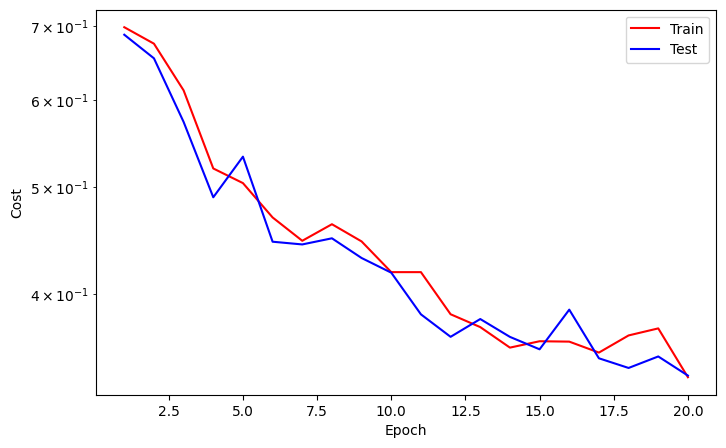

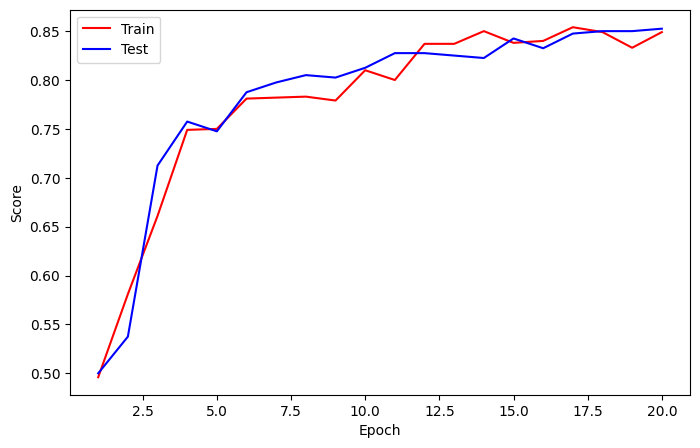

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3341 | Test_cost  = 0.3481 | Train_score = 0.8430 | Test_score = 0.8325 |
==> EarlyStop patience =  1 | Best test_score: 0.8525


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3141 | Test_cost  = 0.3284 | Train_score = 0.8650 | Test_score = 0.8475 |
==> EarlyStop patience =  2 | Best test_score: 0.8525


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3118 | Test_cost  = 0.3044 | Train_score = 0.8590 | Test_score = 0.8500 |
==> EarlyStop patience =  3 | Best test_score: 0.8525


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3079 | Test_cost  = 0.3239 | Train_score = 0.8650 | Test_score = 0.8400 |
==> EarlyStop patience =  4 | Best test_score: 0.8525


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2970 | Test_cost  = 0.3053 | Train_score = 0.8760 | Test_score = 0.8525 |
==> EarlyStop patience =  5 | Best test_score: 0.8525
==> Execute Early Stopping at epoch: 25 | Best test_score: 0.8525
==> Best model is saved at model


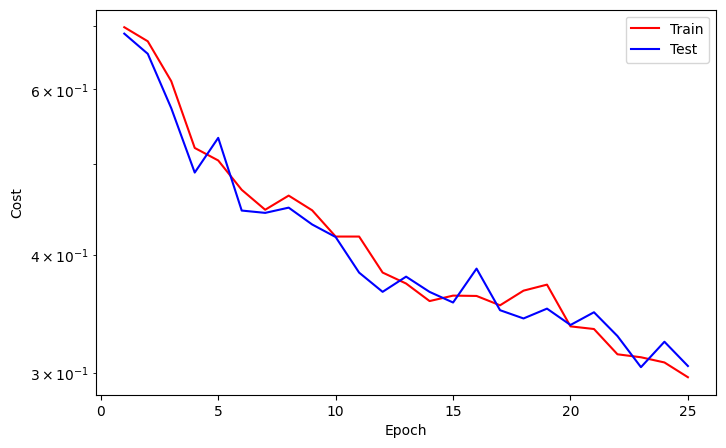

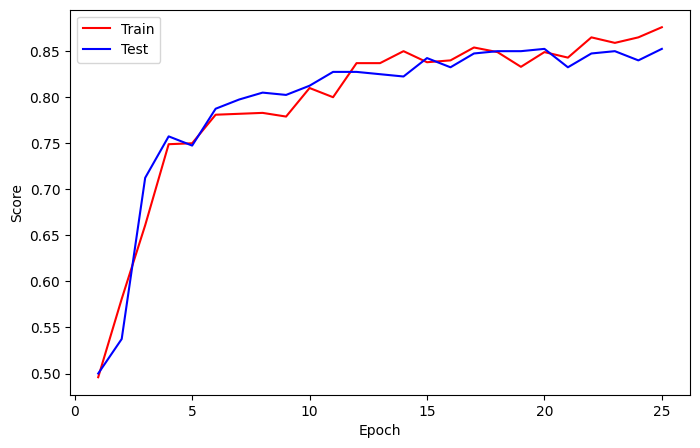

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

# Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')

In [ ]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

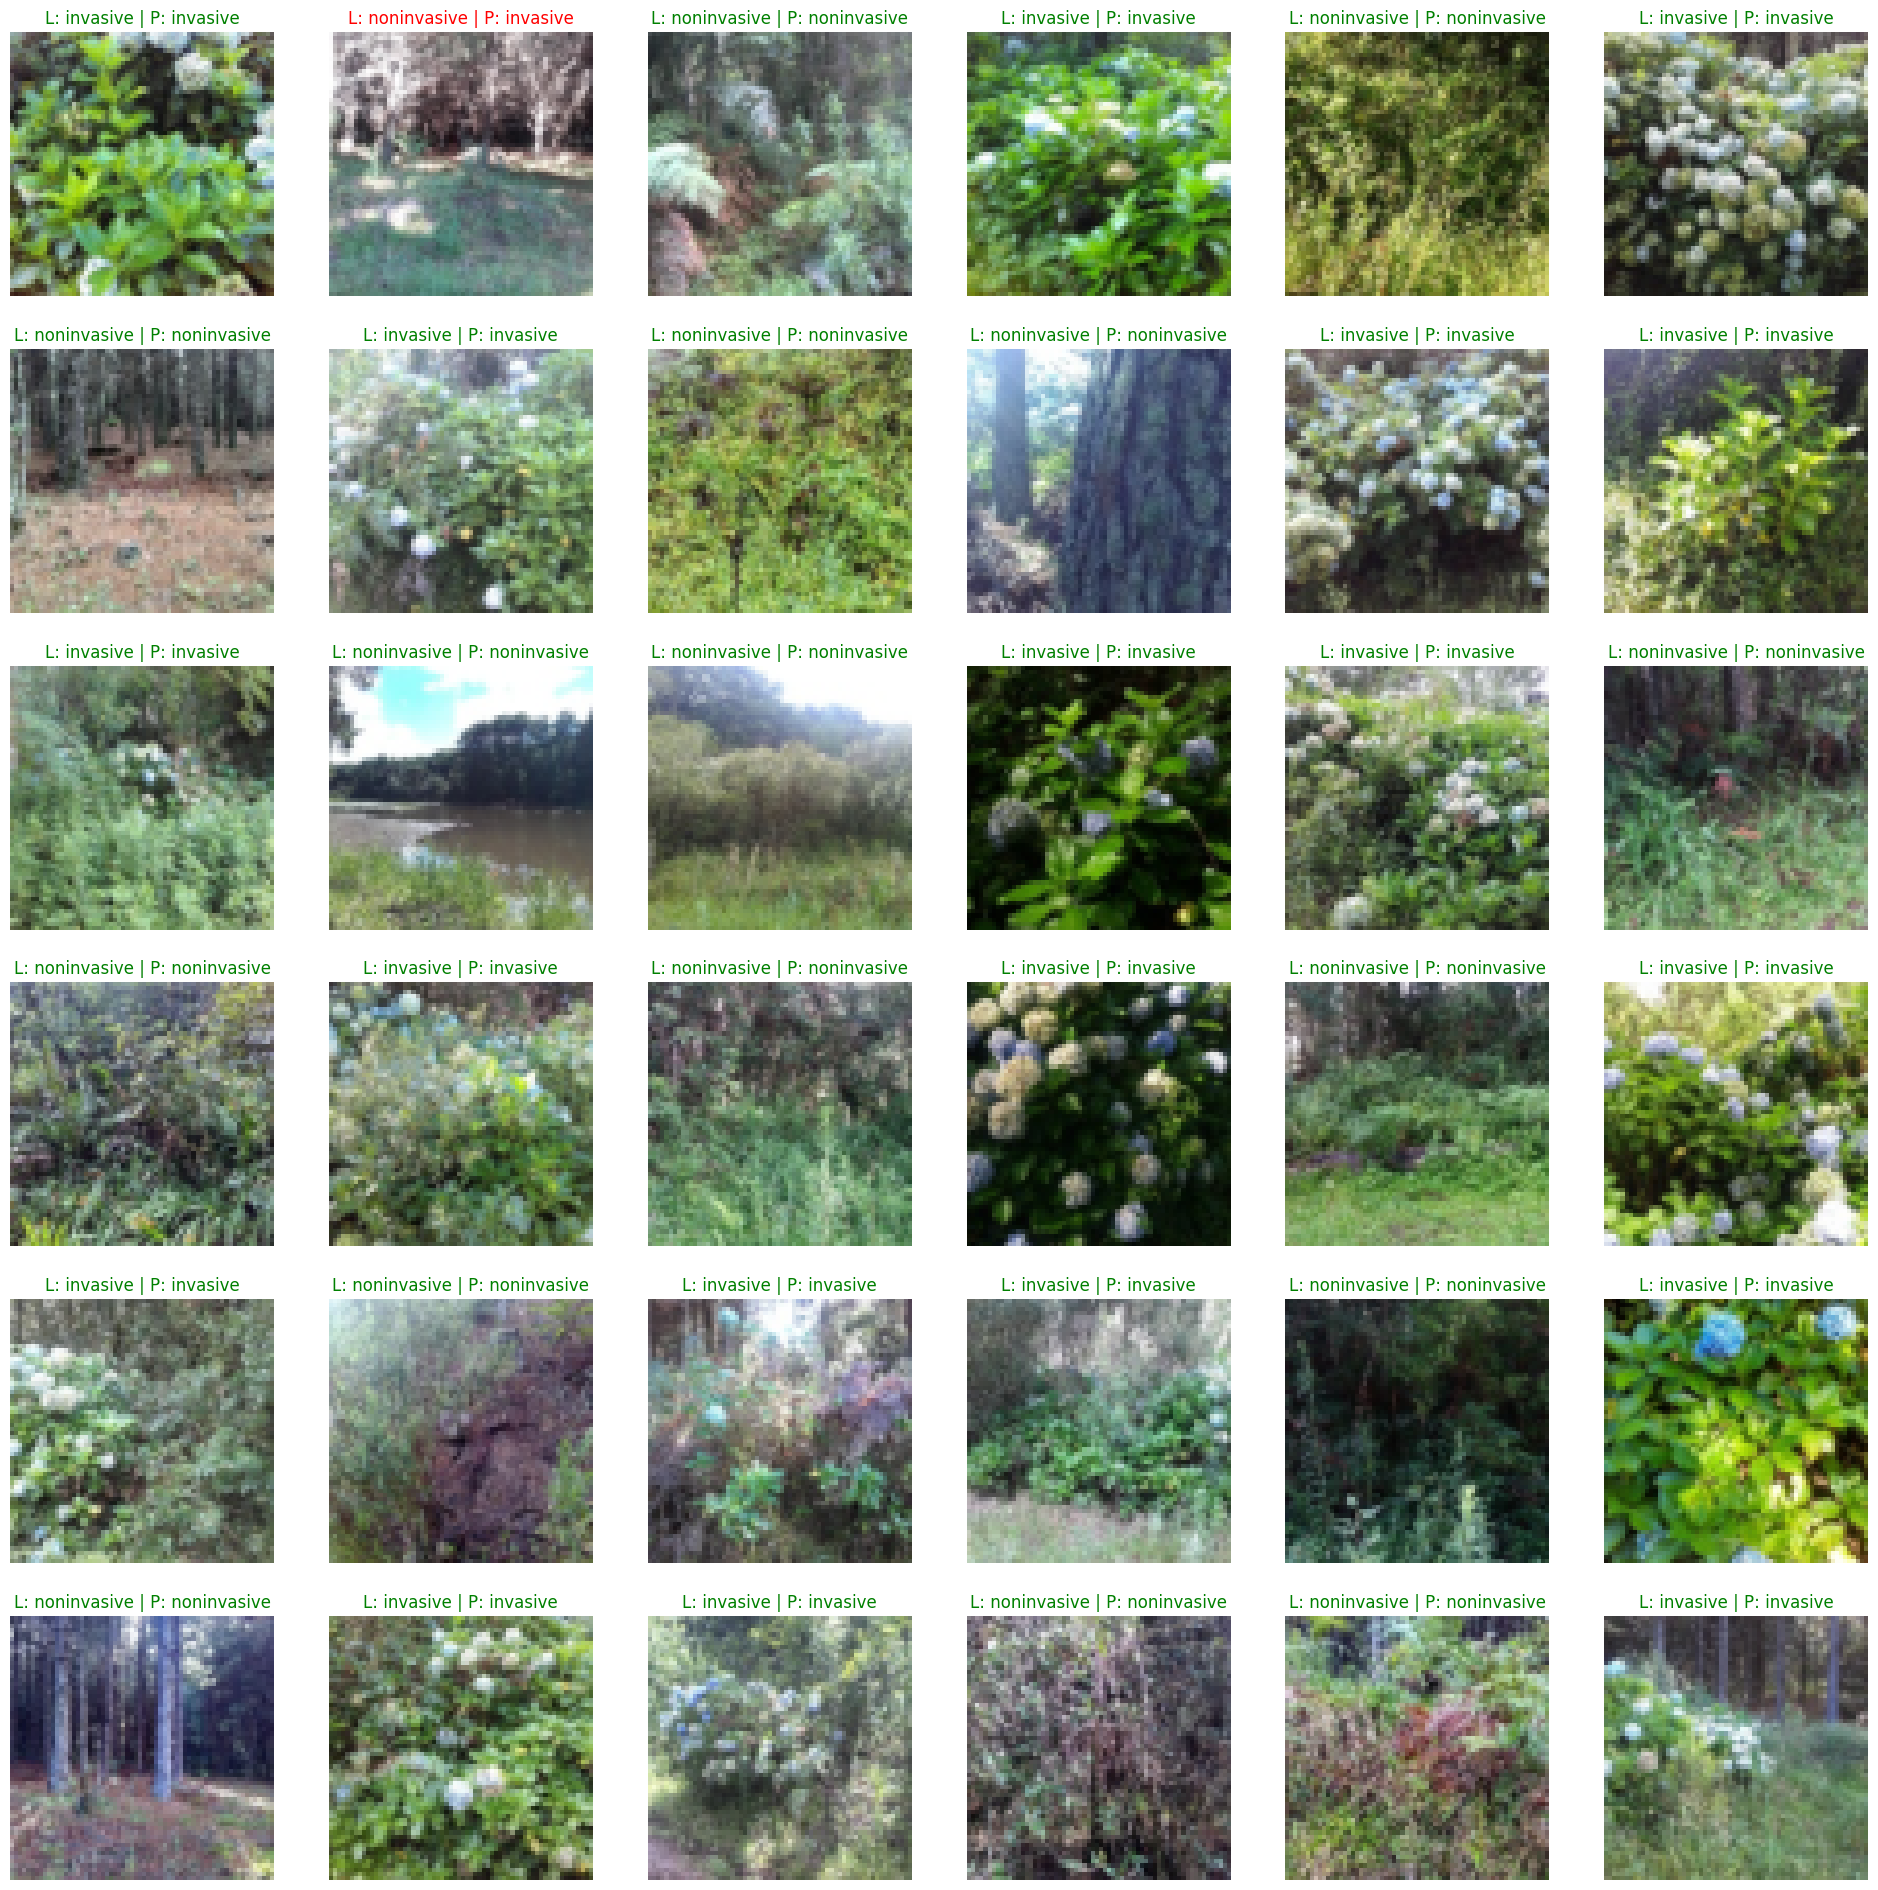

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in  zip(feature, target, preds, axes.flatten()):
  ax.imshow(image.permute(1, 2, 0).cpu())
  font = {"color": 'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
  ax.axis('off');